# Data and Imports

In [1]:



import pandas as pd
import numpy as np
import jsonlines
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import torch.nn as nn
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch_optimizer as optim
import os

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from importlib import reload
pd.set_option('display.max_rows', 500)
pd.set_option('display.float_format', '{:0.3f}'.format)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.width = 0
import warnings
import torchvision
warnings.filterwarnings('ignore')

from facebook_hateful_memes_detector.utils.globals import set_global, get_global
set_global("cache_dir", "/home/ahemf/cache/cache")
set_global("dataloader_workers", 4)
set_global("use_autocast", True)
set_global("models_dir", "/home/ahemf/cache/")

from facebook_hateful_memes_detector.utils import read_json_lines_into_df, in_notebook, set_device, my_collate
get_global("cache_dir")
from facebook_hateful_memes_detector.models import Fasttext1DCNNModel, MultiImageMultiTextAttentionEarlyFusionModel, LangFeaturesModel, AlbertClassifer
from facebook_hateful_memes_detector.preprocessing import TextImageDataset, get_datasets, get_image2torchvision_transforms, TextAugment
from facebook_hateful_memes_detector.preprocessing import DefinedRotation, QuadrantCut, ImageAugment
from facebook_hateful_memes_detector.training import *
import facebook_hateful_memes_detector
reload(facebook_hateful_memes_detector)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
set_device(device)
device


device(type='cuda')

- What Augs are useful
- What Text models perform best

In [2]:

def get_preprocess_text():
    char_level = {"keyboard": 0.1, "char_substitute": 0.4, "char_insert": 0.2, "char_swap": 0.2, 
                  "ocr": 0.0, "char_delete": 0.1}
    char_level = TextAugment([0.1, 0.65, 0.25], char_level)
    word_level = {"split": 0.2,
                 "stopword_insert": 0.5, "word_join": 0.2, "word_cutout": 0.8, "gibberish_insert": 0.0}
    word_level = TextAugment([0.1, 0.65, 0.25], word_level)
    sentence_level = {"text_rotate": 0.0, "sentence_shuffle": 0.0, 
                      "one_third_cut": 0.3, "half_cut":0.0, "part_select": 0.75}
    sentence_level = TextAugment([0.55, 0.45], sentence_level)
    def process(text):
        text = sentence_level(text)
        text = word_level(text)
        text = char_level(text)
        return text
    return process


# choice_probas = {"keyboard": 0.1, "char_substitute": 0.0, "char_insert": 0.1, "char_swap": 0.1, "ocr": 0.0, "char_delete": 0.1,
#                  "fasttext": 0.0, "glove_twitter": 0.0, "glove_wiki": 0.0, "word2vec": 0.0, "split": 0.1,
#                  "stopword_insert": 0.3, "word_join": 0.2, "word_cutout": 0.8,
#                  "text_rotate": 0.0, "sentence_shuffle": 0.0, 
#                  "one_third_cut": 0.3, "half_cut":0.0, "part_select": 0.5}
# preprocess_text = TextAugment([0.05, 0.2, 0.2, 0.3, 0.25], choice_probas, fasttext_file="wiki-news-300d-1M-subword.bin")

# choice_probas_test = {"keyboard": 0.1, "char_substitute": 0.0, "char_insert": 0.1, "char_swap": 0.0, "char_delete": 0.2,
#                  "fasttext": 0.0, "glove_twitter": 0.0, "glove_wiki": 0.0, "word2vec": 0.0, "split": 0.1,
#                  "stopword_insert": 0.3, "word_join": 0.2, "word_cutout": 0.8,
#                  "text_rotate": 0.0, "sentence_shuffle": 0.0, 
#                       "one_third_cut": 0.3, "half_cut":0.0, "part_select": 0.5}

# preprocess_text_test = TextAugment([0.1, 0.9], choice_probas_test, fasttext_file="wiki-news-300d-1M-subword.bin")

preprocess_text = get_preprocess_text()
preprocess_text_test = get_preprocess_text()

data = get_datasets(data_dir="../data/", train_text_transform=preprocess_text, train_image_transform=None, 
                    test_text_transform=None, test_image_transform=None, 
                    cache_images = True, use_images = False, dev=False, test_dev=True,
                    keep_original_text=False, keep_original_image=False, 
                    keep_processed_image=True, keep_torchvision_image=False,)


# Clean text


In [3]:
# data["train"].label.value_counts()
# train = data["train"]

# ones = train[train["label"] == 1]
# zeros = train[train["label"] == 0].sample(n=len(ones), replace=False)
# data["train"] = pd.concat((ones, zeros)).sample(frac=1.0)
# data["train"].label.value_counts()

# len(set(data["train"]["id"])) == data["train"].shape[0]


https://discuss.pytorch.org/t/how-to-implement-torch-optim-lr-scheduler-cosineannealinglr/28797/11

In [4]:


scheduler_init_fn = get_multistep_lr([11, 13], gamma=0.25) # get_cosine_schedule_with_warmup # get_cosine_with_hard_restarts_schedule_with_warmup
scheduler_init_fn = get_constant_schedule_with_warmup(0.3)
# scheduler_init_fn = get_cosine_schedule_with_warmup()
reg_sched = get_regularizer_scheduler()



# Params

In [6]:
sgd = torch.optim.SGD
sgd_params = dict(lr=2e-2, momentum=0.9, dampening=0, weight_decay=0, nesterov=False)

rangerQH = optim.RangerQH
rangerQHparams = dict(lr=1e-3, betas=(0.9, 0.999), nus=(.7, 1.0),
    weight_decay=0.0,
    k=6,
    alpha=.5,
    decouple_weight_decay=True,
    eps=1e-8,)

adam = torch.optim.Adam
adam_params = params=dict(lr=1e-3, weight_decay=1e-7)

adamw = torch.optim.AdamW
adamw_params = dict(lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-2)

novograd = optim.NovoGrad
novograd_params = dict(lr= 1e-3,
    betas=(0.9, 0.999),
    eps=1e-8,
    weight_decay=0,
    grad_averaging=False,
    amsgrad=False,)

qhadam = optim.QHAdam
qhadam_params = dict(lr= 1e-3,
    betas=(0.9, 0.999),
    nus=(1.0, 1.0),
    weight_decay=0,
    decouple_weight_decay=False,
    eps=1e-8,)

radam = optim.RAdam
radam_params = dict(lr= 1e-3,
    betas=(0.9, 0.999),
    eps=1e-8,
    weight_decay=0,)

yogi = optim.Yogi
yogi_params = dict(lr= 1e-2,
    betas=(0.9, 0.999),
    eps=1e-3,
    initial_accumulator=1e-6,
    weight_decay=0)




# BERT Models

## Non Ensemble

In [ ]:
adamw = torch.optim.AdamW
adamw_params = dict(lr=5e-5, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-3)
optimizer = adamw
optimizer_params = adamw_params

lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "layer": {
                "2": {
                    "lr": optimizer_params["lr"],
                    "finetune": False
                },
                "3": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "4": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "5": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                }
            }
        },
    }
}

epochs = 24
batch_size = 256
model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=768,
                              num_classes=2,
                              gaussian_noise=0.05,
                              dropout=0.05,
                              word_masking_proba=0.1,
                              internal_dims=768,
                              final_layer_builder=fb_1d_loss_builder,
                              n_layers=2,
                              n_encoders=0,
                              n_decoders=1,
                              n_tokens_in=96,
                              n_tokens_out=16,
                              featurizer="transformer",
                              model='distilbert-nsp',
                              loss="focal",
                              classification_head="cnn1d", # head_ensemble
                              dice_loss_coef=0.0,
                              auc_loss_coef=0.5, # 0.1
                              attention_drop_proba=0.0,
                              finetune=False),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)

kfold = False
results, prfs = train_validate_ntimes(
    model_fn,
    data,
    batch_size,
    epochs,
    kfold=kfold,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched, # reg_sched
    validation_epochs=[1, 4, 7, 9, 11, 14, 17, 19, 23, 27, 31, 34, 37, 41, 44, 47, 51, 54],
    show_model_stats=False,
    sampling_policy="without_replacement")
r2, p2 = results, prfs
results
prfs

# 0.851	0.666


In [ ]:
adamw = torch.optim.AdamW
adamw_params = dict(lr=5e-5, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-3)
optimizer = adamw
optimizer_params = adamw_params

lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "layer": {
                "2": {
                    "lr": optimizer_params["lr"],
                    "finetune": False
                },
                "3": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "4": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "5": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                }
            }
        },
    }
}

epochs = 24
batch_size = 256
model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=768,
                              num_classes=2,
                              gaussian_noise=0.05,
                              dropout=0.05,
                              word_masking_proba=0.1,
                              internal_dims=768,
                              final_layer_builder=fb_1d_loss_builder,
                              n_layers=2,
                              n_encoders=0,
                              n_decoders=1,
                              n_tokens_in=96,
                              n_tokens_out=16,
                              featurizer="transformer",
                              model='distilbert-nsp',
                              loss="focal",
                              classification_head="cnn1d", # head_ensemble
                              dice_loss_coef=0.0,
                              auc_loss_coef=0.5, # 0.1
                              attention_drop_proba=0.05,
                              finetune=False),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)

kfold = False
results, prfs = train_validate_ntimes(
    model_fn,
    data,
    batch_size,
    epochs,
    kfold=kfold,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched, # reg_sched
    validation_epochs=[1, 4, 7, 9, 11, 14, 17, 19, 23, 27, 31, 34, 37, 41, 44, 47, 51, 54],
    show_model_stats=False,
    sampling_policy="without_replacement")
r2, p2 = results, prfs
results
prfs




## Head Ensemble

In [ ]:
adamw = torch.optim.AdamW
adamw_params = dict(lr=5e-5, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-3)
optimizer = adamw
optimizer_params = adamw_params

lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "layer": {
                "2": {
                    "lr": optimizer_params["lr"],
                    "finetune": False
                },
                "3": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "4": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "5": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                }
            }
        },
    }
}

epochs = 24
batch_size = 256
model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=768,
                              num_classes=2,
                              gaussian_noise=0.0,
                              dropout=0.05,
                              word_masking_proba=0.1, # 0.1
                              internal_dims=768,
                              final_layer_builder=fb_1d_loss_builder,
                              n_layers=2,
                              n_encoders=0,
                              n_decoders=1,
                              n_tokens_in=96,
                              n_tokens_out=16,
                              featurizer="transformer",
                              model='distilbert-nsp',
                              loss="focal",
                              classification_head="head_ensemble", # head_ensemble
                              dice_loss_coef=0.0,
                              auc_loss_coef=0.5, # 0.1
                              attention_drop_proba=0.05,
                              finetune=False),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)

kfold = False
results, prfs = train_validate_ntimes(
    model_fn,
    data,
    batch_size,
    epochs,
    kfold=kfold,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched, # reg_sched
    validation_epochs=[17, 27, 32, 37, 41, 44, 54],
    show_model_stats=False,
    sampling_policy="without_replacement",
    prediction_iters=1, evaluate_in_train_mode=False
)
r2, p2 = results, prfs
results
prfs



## Multi-eval Head Ensemble


In [ ]:
adamw = torch.optim.AdamW
adamw_params = dict(lr=5e-5, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-3)
optimizer = adamw
optimizer_params = adamw_params

lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "layer": {
                "2": {
                    "lr": optimizer_params["lr"],
                    "finetune": False
                },
                "3": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "4": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "5": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                }
            }
        },
    }
}

epochs = 20
batch_size = 256
model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=768,
                              num_classes=2,
                              gaussian_noise=0.0,
                              dropout=0.1,
                              word_masking_proba=0.1, # 0.1
                              internal_dims=768,
                              final_layer_builder=fb_1d_loss_builder,
                              n_layers=2,
                              n_encoders=0,
                              n_decoders=1,
                              n_tokens_in=96,
                              n_tokens_out=16,
                              featurizer="transformer",
                              model='distilbert-nsp',
                              loss="focal",
                              classification_head="head_ensemble", # head_ensemble
                              dice_loss_coef=0.0,
                              auc_loss_coef=0.5, # 0.1
                              attention_drop_proba=0.0,
                              finetune=False),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)

kfold = False
results, prfs = train_validate_ntimes(
    model_fn,
    data,
    batch_size,
    epochs,
    kfold=kfold,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched, # reg_sched
    validation_epochs=[17, 27, 32, 37, 41, 44, 54],
    show_model_stats=False,
    sampling_policy="without_replacement",
    prediction_iters=5, evaluate_in_train_mode=True
)
r2, p2 = results, prfs
results
prfs

# 0.799	0.657 gaussian_noise=0.0, dropout=0.05, word_masking_proba=0.1,
# 0.780	0.634 gaussian_noise=0.0, dropout=0.05, word_masking_proba=0.15, 
# 0.806	0.648 gaussian_noise=0.0, dropout=0.02, word_masking_proba=0.1
# 0.803	0.655 gaussian_noise=0.0, dropout=0.1, word_masking_proba=0.1, (0.807	0.657) 0.803	0.653


## Decoder Ensemble

### Train All Params

Pick stored Model /home/ahemf/cache/distilbert-nsp Model Class =  <class 'transformers.modeling_roberta.RobertaModel'> Tokenizer Class =  <class 'transformers.tokenization_roberta.RobertaTokenizer'>
Autocast =  True Epochs =  48 Divisor = 2 Examples = 4250 Batch Size =  256
Training Samples =  8500 Weighted Sampling =  True Num Batches =  17 Accumulation steps =  1



Epoch =  1 Loss = 0.718772 LR = 0.00000348



Epoch =  2 Loss = 0.550060 LR = 0.00000697



Epoch =  3 Loss = 0.498758 LR = 0.00001045



Epoch =  4 Loss = 0.483025 LR = 0.00001393



Epoch =  5 Loss = 0.474293 LR = 0.00001742



Epoch =  6 Loss = 0.468750 LR = 0.00002090



Epoch =  7 Loss = 0.464112 LR = 0.00002439



Epoch =  8 Loss = 0.445096 LR = 0.00002787



Epoch =  9 Loss = 0.433669 LR = 0.00003135



Epoch =  10 Loss = 0.427765 LR = 0.00003484



Epoch =  11 Loss = 0.410222 LR = 0.00003832



Epoch =  12 Loss = 0.407620 LR = 0.00004180



Epoch =  13 Loss = 0.395988 LR = 0.00004529



Epoch =  14 Loss = 0.392119 LR = 0.00004877



Epoch =  15 Loss = 0.388016 LR = 0.00004995



Epoch =  16 Loss = 0.378539 LR = 0.00004970



Epoch =  17 Loss = 0.380119 LR = 0.00004924


Proba       Preds    
         min   max   min max
Labels                      
0      0.257 0.767     0   1
1      0.350 0.791     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.461,"[0.5391131639480591, 0.46088677644729614]",0,0,0.362,"[0.6375855803489685, 0.3624144196510315]",0,0,0.485,"[0.5150215029716492, 0.48497849702835083]",0,0
1,0.502,"[0.49781566858291626, 0.5021843314170837]",1,1,0.473,"[0.5270142555236816, 0.47298574447631836]",0,1,0.731,"[0.26916807889938354, 0.7308319211006165]",1,0
2,0.667,"[0.33346617221832275, 0.6665338277816772]",1,0,0.685,"[0.3153882324695587, 0.6846117377281189]",1,1,0.484,"[0.5161066055297852, 0.48389342427253723]",0,1
3,0.606,"[0.3939986824989319, 0.6060013175010681]",1,0,0.565,"[0.43538790941238403, 0.5646121501922607]",1,1,0.491,"[0.5088193416595459, 0.4911806881427765]",0,1
4,0.690,"[0.3097067177295685, 0.6902932524681091]",1,1,0.411,"[0.5887421369552612, 0.41125786304473877]",0,0,0.530,"[0.47012901306152344, 0.5298709869384766]",1,1


scores =  {'map': '0.6070', 'acc': '0.5820', 'auc': '0.6408'}
Epoch =  17 Train = 0.793770 Val = 0.640816



Epoch =  18 Loss = 0.363576 LR = 0.00004856



Epoch =  19 Loss = 0.350770 LR = 0.00004768



Epoch =  20 Loss = 0.351472 LR = 0.00004660



Epoch =  21 Loss = 0.350841 LR = 0.00004534



Epoch =  22 Loss = 0.362643 LR = 0.00004389



Epoch =  23 Loss = 0.353840 LR = 0.00004229



Epoch =  24 Loss = 0.353242 LR = 0.00004053



Epoch =  25 Loss = 0.346662 LR = 0.00003863



Epoch =  26 Loss = 0.337099 LR = 0.00003662


Exception for:  keyboard | ' ' ' ' | ['char_delete' 'keyboard'] argument of type 'NoneType' is not iterable

Epoch =  27 Loss = 0.338021 LR = 0.00003450


Proba       Preds    
         min   max   min max
Labels                      
0      0.116 0.820     0   1
1      0.218 0.804     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.536,"[0.4635389447212219, 0.5364610552787781]",1,0,0.500,"[0.500245213508606, 0.49975472688674927]",0,0,0.638,"[0.3620915412902832, 0.6379084587097168]",1,1
1,0.401,"[0.5989819765090942, 0.40101802349090576]",0,1,0.444,"[0.5563808083534241, 0.4436192214488983]",0,1,0.318,"[0.682303249835968, 0.317696750164032]",0,0
2,0.598,"[0.40168994665145874, 0.5983099937438965]",1,0,0.414,"[0.5861711502075195, 0.4138287901878357]",0,0,0.383,"[0.6168411374092102, 0.383158802986145]",0,0
3,0.426,"[0.5743964910507202, 0.425603449344635]",0,0,0.526,"[0.47432202100753784, 0.5256779789924622]",1,1,0.302,"[0.6977944374084473, 0.30220553278923035]",0,1
4,0.297,"[0.7027177810668945, 0.2972821593284607]",0,0,0.586,"[0.4137776494026184, 0.5862222909927368]",1,1,0.307,"[0.69254469871521, 0.30745524168014526]",0,0


scores =  {'map': '0.6090', 'acc': '0.5840', 'auc': '0.6449'}
Epoch =  27 Train = 0.826394 Val = 0.644920



Epoch =  28 Loss = 0.334243 LR = 0.00003231



Epoch =  29 Loss = 0.337152 LR = 0.00003005



Epoch =  30 Loss = 0.338960 LR = 0.00002774



Epoch =  31 Loss = 0.345512 LR = 0.00002541



Epoch =  32 Loss = 0.327440 LR = 0.00002308



Epoch =  33 Loss = 0.332765 LR = 0.00002076



Epoch =  34 Loss = 0.335312 LR = 0.00001849


Proba       Preds    
         min   max   min max
Labels                      
0      0.062 0.790     0   1
1      0.118 0.785     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.375,"[0.6246748566627502, 0.37532514333724976]",0,1,0.474,"[0.5260006785392761, 0.4739993214607239]",0,0,0.199,"[0.8013868927955627, 0.19861312210559845]",0,0
1,0.626,"[0.37433922290802, 0.6256607174873352]",1,0,0.252,"[0.7484865188598633, 0.2515134811401367]",0,0,0.613,"[0.38710659742355347, 0.6128933429718018]",1,1
2,0.347,"[0.6533840298652649, 0.34661591053009033]",0,1,0.414,"[0.5856658816337585, 0.41433411836624146]",0,0,0.526,"[0.47387635707855225, 0.526123583316803]",1,1
3,0.405,"[0.5947701930999756, 0.40522974729537964]",0,1,0.372,"[0.6279582381248474, 0.3720417022705078]",0,0,0.180,"[0.8197525143623352, 0.18024751543998718]",0,0
4,0.502,"[0.4975951015949249, 0.5024048089981079]",1,1,0.159,"[0.8406492471694946, 0.1593507081270218]",0,1,0.369,"[0.6312727928161621, 0.3687271773815155]",0,1


scores =  {'map': '0.6057', 'acc': '0.5620', 'auc': '0.6462'}
Epoch =  34 Train = 0.841295 Val = 0.646192



Epoch =  35 Loss = 0.330259 LR = 0.00001626



Epoch =  36 Loss = 0.333742 LR = 0.00001412



Epoch =  37 Loss = 0.334051 LR = 0.00001207



Epoch =  38 Loss = 0.331695 LR = 0.00001013


Exception for:  keyboard | '' '' | ['keyboard'] argument of type 'NoneType' is not iterable

Epoch =  39 Loss = 0.327759 LR = 0.00000832



Epoch =  40 Loss = 0.328073 LR = 0.00000666



Epoch =  41 Loss = 0.324816 LR = 0.00000515


Proba       Preds    
         min   max   min max
Labels                      
0      0.047 0.775     0   1
1      0.107 0.816     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.418,"[0.5821535587310791, 0.41784635186195374]",0,0,0.316,"[0.6843077540397644, 0.3156922459602356]",0,0,0.355,"[0.6450698375701904, 0.3549301028251648]",0,1
1,0.491,"[0.5089985132217407, 0.4910014569759369]",0,1,0.275,"[0.7253762483596802, 0.2746237814426422]",0,0,0.641,"[0.35865893959999084, 0.6413410305976868]",1,0
2,0.534,"[0.4661112129688263, 0.5338887572288513]",1,0,0.343,"[0.6566886901855469, 0.3433113098144531]",0,0,0.527,"[0.47314882278442383, 0.5268511772155762]",1,1
3,0.407,"[0.592505693435669, 0.40749430656433105]",0,1,0.406,"[0.5940530896186829, 0.40594685077667236]",0,0,0.454,"[0.546270489692688, 0.45372945070266724]",0,0
4,0.444,"[0.5562214255332947, 0.44377854466438293]",0,0,0.351,"[0.6485176086425781, 0.35148242115974426]",0,0,0.200,"[0.8003178238868713, 0.1996820867061615]",0,0


scores =  {'map': '0.6082', 'acc': '0.5580', 'auc': '0.6465'}
Epoch =  41 Train = 0.848161 Val = 0.646512



Epoch =  42 Loss = 0.323047 LR = 0.00000382



Epoch =  43 Loss = 0.329718 LR = 0.00000268



Epoch =  44 Loss = 0.331861 LR = 0.00000172



Epoch =  45 Loss = 0.328100 LR = 0.00000097



Epoch =  46 Loss = 0.329676 LR = 0.00000043



Epoch =  47 Loss = 0.323695 LR = 0.00000011


Proba       Preds    
         min   max   min max
Labels                      
0      0.058 0.791     0   1
1      0.119 0.817     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.330,"[0.6696552634239197, 0.3303447365760803]",0,1,0.314,"[0.686339259147644, 0.31366071105003357]",0,1,0.629,"[0.37136155366897583, 0.6286383867263794]",1,0
1,0.755,"[0.2447725087404251, 0.7552274465560913]",1,1,0.464,"[0.5361583232879639, 0.46384161710739136]",0,0,0.694,"[0.30621734261512756, 0.69378262758255]",1,1
2,0.326,"[0.6737571358680725, 0.3262428343296051]",0,0,0.671,"[0.329273521900177, 0.6707264184951782]",1,1,0.556,"[0.44425448775291443, 0.5557454824447632]",1,1
3,0.382,"[0.6184097528457642, 0.38159021735191345]",0,0,0.534,"[0.46580037474632263, 0.534199595451355]",1,1,0.648,"[0.3519119620323181, 0.6480880379676819]",1,1
4,0.677,"[0.32348841428756714, 0.6765115261077881]",1,0,0.498,"[0.5016240477561951, 0.49837589263916016]",0,1,0.571,"[0.42937171459198, 0.57062828540802]",1,0


scores =  {'map': '0.6114', 'acc': '0.5640', 'auc': '0.6508'}
Epoch =  47 Train = 0.849509 Val = 0.650800



Epoch =  48 Loss = 0.322944 LR = 0.00000000



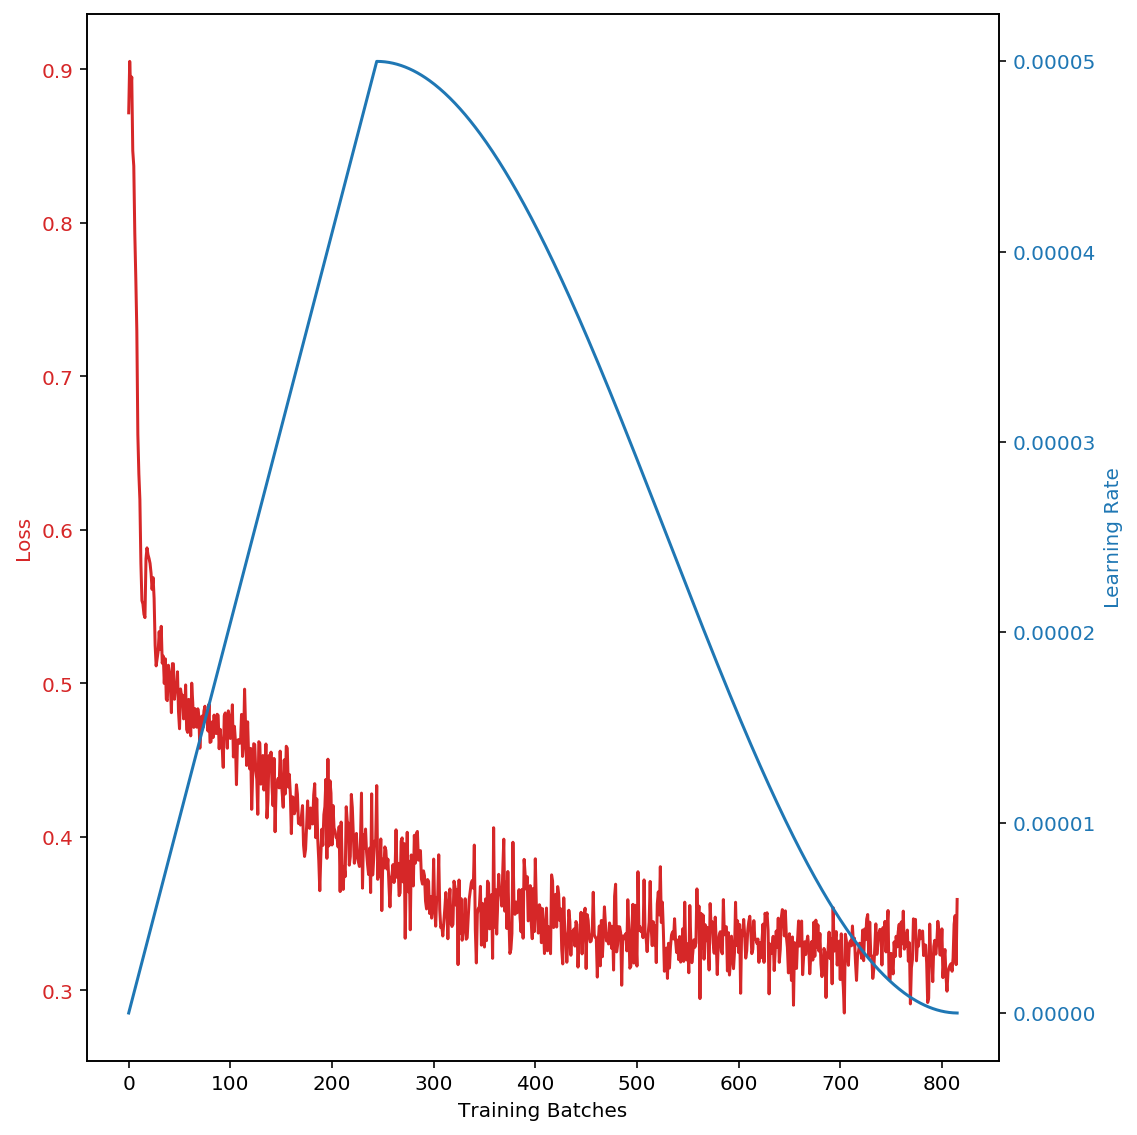

Proba       Preds    
         min   max   min max
Labels                      
0      0.058 0.792     0   1
1      0.119 0.818     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.506,"[0.4943177103996277, 0.5056822896003723]",1,0,0.458,"[0.5419405102729797, 0.45805948972702026]",0,1,0.417,"[0.5834930539131165, 0.41650694608688354]",0,0
1,0.480,"[0.519960343837738, 0.48003965616226196]",0,1,0.370,"[0.6301073431968689, 0.36989259719848633]",0,0,0.439,"[0.5610328912734985, 0.4389670789241791]",0,1
2,0.385,"[0.6153403520584106, 0.38465964794158936]",0,0,0.416,"[0.5844233632087708, 0.41557660698890686]",0,0,0.707,"[0.29274964332580566, 0.7072503566741943]",1,0
3,0.326,"[0.6741451621055603, 0.3258548676967621]",0,0,0.499,"[0.5005703568458557, 0.4994296133518219]",0,1,0.682,"[0.3184809982776642, 0.6815189719200134]",1,1
4,0.291,"[0.7093660831451416, 0.2906338572502136]",0,1,0.369,"[0.6306499242782593, 0.3693500757217407]",0,1,0.414,"[0.5855351686477661, 0.4144647717475891]",0,0


scores =  {'map': '0.6114', 'acc': '0.5680', 'auc': '0.6508'}


train   val
mean_or_std metric               
mean        map       0.780 0.611
            accuracy  0.771 0.568
            auc       0.850 0.651
std         map       0.000 0.000
            accuracy  0.000 0.000
            auc       0.000 0.000

train                             val                     
    precision recall    f1  supoort precision recall    f1 supoort
neg     0.835  0.801 0.817 5450.000     0.552  0.728 0.628 250.000
pos     0.668  0.717 0.692 3050.000     0.600  0.408 0.486 250.000

In [31]:
adamw = torch.optim.AdamW
adamw_params = dict(lr=5e-5, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-3)
optimizer = adamw
optimizer_params = adamw_params

lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "layer": {
                "2": {
                    "lr": optimizer_params["lr"],
                    "finetune": False
                },
                "3": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "4": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "5": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                }
            }
        },
    }
}

epochs = 24
batch_size = 256
model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=768,
                              num_classes=2,
                              gaussian_noise=0.01,
                              dropout=0.025,
                              word_masking_proba=0.1,
                              internal_dims=768,
                              final_layer_builder=fb_1d_loss_builder,
                              n_layers=2,
                              n_encoders=0,
                              n_decoders=0,
                              n_tokens_in=96,
                              n_tokens_out=48,
                              featurizer="transformer",
                              model='distilbert-nsp',
                              loss="focal",
                              classification_head="decoder_ensemble", # head_ensemble
                              dice_loss_coef=0.0,
                              auc_loss_coef=0.5, # 0.1
                              attention_drop_proba=0.0,
                              finetune=False,
                              n_classifier_layers=1,
                              n_classifier_decoders=16, # 4
                             ),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)

kfold = False
results, prfs = train_validate_ntimes(
    model_fn,
    data,
    batch_size,
    epochs,
    kfold=kfold,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched, # reg_sched
    validation_epochs=[17, 27, 34, 41, 47, 51, 54],
    show_model_stats=False,
    sampling_policy="without_replacement",
    prediction_iters=1, evaluate_in_train_mode=False
)
r2, p2 = results, prfs
results
prfs

# 0.854	0.654 0.651 0.646 x2
# MLM = 0.854	0.646
# No focal 0.851	0.647 (0.766	0.556)


Pick stored Model /home/ahemf/cache/distilbert-nsp Model Class =  <class 'transformers.modeling_roberta.RobertaModel'> Tokenizer Class =  <class 'transformers.tokenization_roberta.RobertaTokenizer'>
Autocast =  True Epochs =  56 Divisor = 2 Examples = 4250 Batch Size =  256
Training Samples =  8500 Weighted Sampling =  True Num Batches =  17 Accumulation steps =  1



Epoch =  1 Loss = 0.693817 LR = 0.00000149



Epoch =  2 Loss = 0.592762 LR = 0.00000298



Epoch =  3 Loss = 0.566228 LR = 0.00000447



Epoch =  4 Loss = 0.555877 LR = 0.00000596



Epoch =  5 Loss = 0.548087 LR = 0.00000746



Epoch =  6 Loss = 0.530008 LR = 0.00000895



Epoch =  7 Loss = 0.513579 LR = 0.00001044



Epoch =  8 Loss = 0.499346 LR = 0.00001193



Epoch =  9 Loss = 0.497599 LR = 0.00001342



Epoch =  10 Loss = 0.505649 LR = 0.00001491



Epoch =  11 Loss = 0.470327 LR = 0.00001640



Epoch =  12 Loss = 0.465575 LR = 0.00001789



Epoch =  13 Loss = 0.456832 LR = 0.00001939



Epoch =  14 Loss = 0.441019 LR = 0.00002088



Epoch =  15 Loss = 0.443088 LR = 0.00002237



Epoch =  16 Loss = 0.447570 LR = 0.00002386



Epoch =  17 Loss = 0.438798 LR = 0.00002500


Proba       Preds    
         min   max   min max
Labels                      
0      0.083 0.678     0   1
1      0.140 0.718     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.326,"[0.6735860109329224, 0.32641392946243286]",0,1,0.321,"[0.6792784929275513, 0.32072144746780396]",0,0,0.407,"[0.5925323963165283, 0.4074675440788269]",0,1
1,0.552,"[0.4476003646850586, 0.5523996353149414]",1,1,0.395,"[0.6047577261924744, 0.39524227380752563]",0,0,0.111,"[0.888601541519165, 0.11139844357967377]",0,0
2,0.331,"[0.6685856580734253, 0.3314144015312195]",0,1,0.212,"[0.7884982824325562, 0.21150171756744385]",0,1,0.237,"[0.762617826461792, 0.23738214373588562]",0,1
3,0.289,"[0.7113529443740845, 0.28864702582359314]",0,0,0.136,"[0.8640451431274414, 0.13595479726791382]",0,0,0.417,"[0.5832287073135376, 0.4167712926864624]",0,0
4,0.305,"[0.6950263977050781, 0.3049735426902771]",0,1,0.612,"[0.38764163851737976, 0.6123583316802979]",1,1,0.143,"[0.8569101691246033, 0.14308983087539673]",0,0


scores =  {'map': '0.5963', 'acc': '0.5240', 'auc': '0.6231'}
Epoch =  17 Train = 0.784517 Val = 0.623120


Exception for:  keyboard | '' | ['keyboard'] argument of type 'NoneType' is not iterable

Epoch =  18 Loss = 0.436490 LR = 0.00002494



Epoch =  19 Loss = 0.414530 LR = 0.00002480



Epoch =  20 Loss = 0.408522 LR = 0.00002458



Epoch =  21 Loss = 0.410029 LR = 0.00002429


Exception for:  keyboard | '' | ['keyboard'] argument of type 'NoneType' is not iterable

Epoch =  22 Loss = 0.415834 LR = 0.00002392



Epoch =  23 Loss = 0.433877 LR = 0.00002347



Epoch =  24 Loss = 0.397888 LR = 0.00002296



Epoch =  25 Loss = 0.389034 LR = 0.00002238



Epoch =  26 Loss = 0.400461 LR = 0.00002174



Epoch =  27 Loss = 0.390971 LR = 0.00002103


Proba       Preds    
         min   max   min max
Labels                      
0      0.083 0.697     0   1
1      0.144 0.758     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.332,"[0.6675203442573547, 0.3324796259403229]",0,0,0.255,"[0.7454895377159119, 0.25451040267944336]",0,0,0.672,"[0.328235387802124, 0.6717645525932312]",1,0
1,0.220,"[0.7803990244865417, 0.21960094571113586]",0,0,0.341,"[0.6588400602340698, 0.3411599397659302]",0,1,0.504,"[0.496135950088501, 0.503864049911499]",1,1
2,0.373,"[0.6265850067138672, 0.37341493368148804]",0,1,0.515,"[0.48470839858055115, 0.5152915716171265]",1,1,0.392,"[0.608165979385376, 0.391834020614624]",0,1
3,0.384,"[0.616107165813446, 0.38389286398887634]",0,0,0.173,"[0.8266434669494629, 0.17335650324821472]",0,0,0.384,"[0.616107165813446, 0.38389286398887634]",0,1
4,0.268,"[0.7320501804351807, 0.2679498493671417]",0,0,0.251,"[0.7491154670715332, 0.2508845031261444]",0,1,0.220,"[0.7799413800239563, 0.22005857527256012]",0,1


scores =  {'map': '0.6022', 'acc': '0.5420', 'auc': '0.6313'}
Epoch =  27 Train = 0.816965 Val = 0.631280



Epoch =  28 Loss = 0.384910 LR = 0.00002027



Epoch =  29 Loss = 0.378276 LR = 0.00001947



Epoch =  30 Loss = 0.372948 LR = 0.00001861



Epoch =  31 Loss = 0.365685 LR = 0.00001772



Epoch =  32 Loss = 0.373271 LR = 0.00001680


Exception for:  keyboard | ' ' ' ' | ['char_substitute' 'keyboard'] argument of type 'NoneType' is not iterable

Epoch =  33 Loss = 0.368499 LR = 0.00001584



Epoch =  34 Loss = 0.366455 LR = 0.00001487


Proba       Preds    
         min   max   min max
Labels                      
0      0.096 0.747     0   1
1      0.187 0.811     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.291,"[0.7089537382125854, 0.29104623198509216]",0,1,0.512,"[0.4882551431655884, 0.5117448568344116]",1,0,0.241,"[0.7586216926574707, 0.2413783073425293]",0,0
1,0.293,"[0.7069728374481201, 0.2930271625518799]",0,0,0.528,"[0.47187644243240356, 0.5281236171722412]",1,1,0.228,"[0.7722924947738647, 0.22770747542381287]",0,0
2,0.453,"[0.5474585294723511, 0.4525415003299713]",0,1,0.218,"[0.7819173336029053, 0.21808265149593353]",0,0,0.656,"[0.3436698615550995, 0.6563301086425781]",1,1
3,0.144,"[0.8560547828674316, 0.14394524693489075]",0,0,0.453,"[0.5474836826324463, 0.45251625776290894]",0,1,0.457,"[0.5432570576667786, 0.45674291253089905]",0,1
4,0.532,"[0.4680182933807373, 0.5319817066192627]",1,1,0.583,"[0.41734200716018677, 0.5826579332351685]",1,0,0.527,"[0.47262343764305115, 0.5273765325546265]",1,1


scores =  {'map': '0.6094', 'acc': '0.5500', 'auc': '0.6398'}
Epoch =  34 Train = 0.833769 Val = 0.639760



Epoch =  35 Loss = 0.363882 LR = 0.00001388



Epoch =  36 Loss = 0.359039 LR = 0.00001288



Epoch =  37 Loss = 0.369695 LR = 0.00001188



Epoch =  38 Loss = 0.355604 LR = 0.00001089



Epoch =  39 Loss = 0.354957 LR = 0.00000990



Epoch =  40 Loss = 0.353988 LR = 0.00000893



Epoch =  41 Loss = 0.353639 LR = 0.00000798


Proba       Preds    
         min   max   min max
Labels                      
0      0.069 0.801     0   1
1      0.184 0.779     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.388,"[0.6123794317245483, 0.38762056827545166]",0,0,0.603,"[0.3973381519317627, 0.6026618480682373]",1,1,0.657,"[0.3427031636238098, 0.6572967767715454]",1,0
1,0.518,"[0.4818495810031891, 0.5181503295898438]",1,1,0.604,"[0.3959037661552429, 0.6040961742401123]",1,0,0.425,"[0.5750235915184021, 0.42497631907463074]",0,0
2,0.516,"[0.48368215560913086, 0.5163177847862244]",1,1,0.590,"[0.4097056984901428, 0.5902942419052124]",1,1,0.289,"[0.7113732099533081, 0.2886267900466919]",0,0
3,0.434,"[0.5660718083381653, 0.43392816185951233]",0,1,0.624,"[0.37649106979370117, 0.6235089302062988]",1,1,0.353,"[0.6472706198692322, 0.35272935032844543]",0,0
4,0.340,"[0.6600748896598816, 0.339925080537796]",0,1,0.357,"[0.6432638764381409, 0.35673612356185913]",0,0,0.611,"[0.3893555700778961, 0.6106444001197815]",1,1


scores =  {'map': '0.6067', 'acc': '0.5680', 'auc': '0.6445'}
Epoch =  41 Train = 0.844079 Val = 0.644544



Epoch =  42 Loss = 0.347794 LR = 0.00000707



Epoch =  43 Loss = 0.355471 LR = 0.00000618



Epoch =  44 Loss = 0.349166 LR = 0.00000534



Epoch =  45 Loss = 0.353196 LR = 0.00000454



Epoch =  46 Loss = 0.342063 LR = 0.00000380



Epoch =  47 Loss = 0.348893 LR = 0.00000311


Proba       Preds    
         min   max   min max
Labels                      
0      0.058 0.800     0   1
1      0.150 0.787     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.509,"[0.4913639426231384, 0.5086359977722168]",1,1,0.226,"[0.773829460144043, 0.22617049515247345]",0,0,0.666,"[0.3336986005306244, 0.6663013696670532]",1,1
1,0.571,"[0.4292832314968109, 0.5707167387008667]",1,0,0.489,"[0.510711133480072, 0.489288866519928]",0,1,0.219,"[0.781286358833313, 0.21871358156204224]",0,1
2,0.242,"[0.7576575875282288, 0.24234238266944885]",0,0,0.502,"[0.49778491258621216, 0.5022151470184326]",1,0,0.443,"[0.5574558973312378, 0.4425440728664398]",0,1
3,0.384,"[0.6156567335128784, 0.3843432366847992]",0,0,0.440,"[0.5604334473609924, 0.43956655263900757]",0,1,0.321,"[0.6786003112792969, 0.3213997185230255]",0,1
4,0.190,"[0.809994101524353, 0.19000588357448578]",0,0,0.381,"[0.6188890933990479, 0.38111090660095215]",0,0,0.416,"[0.5836459398269653, 0.41635406017303467]",0,1


scores =  {'map': '0.6059', 'acc': '0.5560', 'auc': '0.6406'}
Epoch =  47 Train = 0.849852 Val = 0.640608



Epoch =  48 Loss = 0.345936 LR = 0.00000248



Epoch =  49 Loss = 0.349147 LR = 0.00000191



Epoch =  50 Loss = 0.343726 LR = 0.00000142



Epoch =  51 Loss = 0.344227 LR = 0.00000099


Proba       Preds    
         min   max   min max
Labels                      
0      0.057 0.801     0   1
1      0.141 0.790     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.306,"[0.6935570240020752, 0.30644291639328003]",0,0,0.320,"[0.6800438165664673, 0.3199561536312103]",0,1,0.402,"[0.5978609323501587, 0.4021390676498413]",0,1
1,0.361,"[0.6394314169883728, 0.3605685234069824]",0,0,0.543,"[0.45663270354270935, 0.5433672666549683]",1,0,0.535,"[0.4645266830921173, 0.5354733467102051]",1,1
2,0.346,"[0.6539775729179382, 0.346022367477417]",0,1,0.434,"[0.5659788846969604, 0.43402108550071716]",0,1,0.205,"[0.794876754283905, 0.2051231861114502]",0,0
3,0.181,"[0.8190778493881226, 0.18092209100723267]",0,0,0.284,"[0.7164740562438965, 0.28352588415145874]",0,1,0.286,"[0.7143470048904419, 0.28565293550491333]",0,0
4,0.513,"[0.4872809648513794, 0.5127189755439758]",1,0,0.352,"[0.6481639742851257, 0.35183602571487427]",0,0,0.366,"[0.634092390537262, 0.36590757966041565]",0,0


scores =  {'map': '0.6103', 'acc': '0.5660', 'auc': '0.6446'}
Epoch =  51 Train = 0.850294 Val = 0.644576



Epoch =  52 Loss = 0.341734 LR = 0.00000064



Epoch =  53 Loss = 0.340628 LR = 0.00000036



Epoch =  54 Loss = 0.344826 LR = 0.00000016


Proba       Preds    
         min   max   min max
Labels                      
0      0.065 0.827     0   1
1      0.159 0.819     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.283,"[0.7166962623596191, 0.28330370783805847]",0,0,0.578,"[0.42221367359161377, 0.5777862071990967]",1,1,0.501,"[0.4988391101360321, 0.5011608600616455]",1,0
1,0.404,"[0.5958144068717957, 0.40418556332588196]",0,1,0.424,"[0.5762948989868164, 0.4237050712108612]",0,1,0.792,"[0.20836807787418365, 0.7916319370269775]",1,0
2,0.111,"[0.8886725902557373, 0.11132741719484329]",0,0,0.320,"[0.6800625324249268, 0.319937527179718]",0,0,0.521,"[0.47883036732673645, 0.5211695432662964]",1,0
3,0.580,"[0.4199727177619934, 0.5800272822380066]",1,1,0.153,"[0.8470019102096558, 0.15299810469150543]",0,0,0.258,"[0.7415542006492615, 0.25844573974609375]",0,1
4,0.402,"[0.5984390377998352, 0.4015609323978424]",0,1,0.426,"[0.5743200778961182, 0.42567992210388184]",0,1,0.628,"[0.37178856134414673, 0.6282113790512085]",1,0


scores =  {'map': '0.6105', 'acc': '0.5680', 'auc': '0.6446'}
Epoch =  54 Train = 0.850712 Val = 0.644576



Epoch =  55 Loss = 0.340601 LR = 0.00000004



Epoch =  56 Loss = 0.342802 LR = 0.00000000



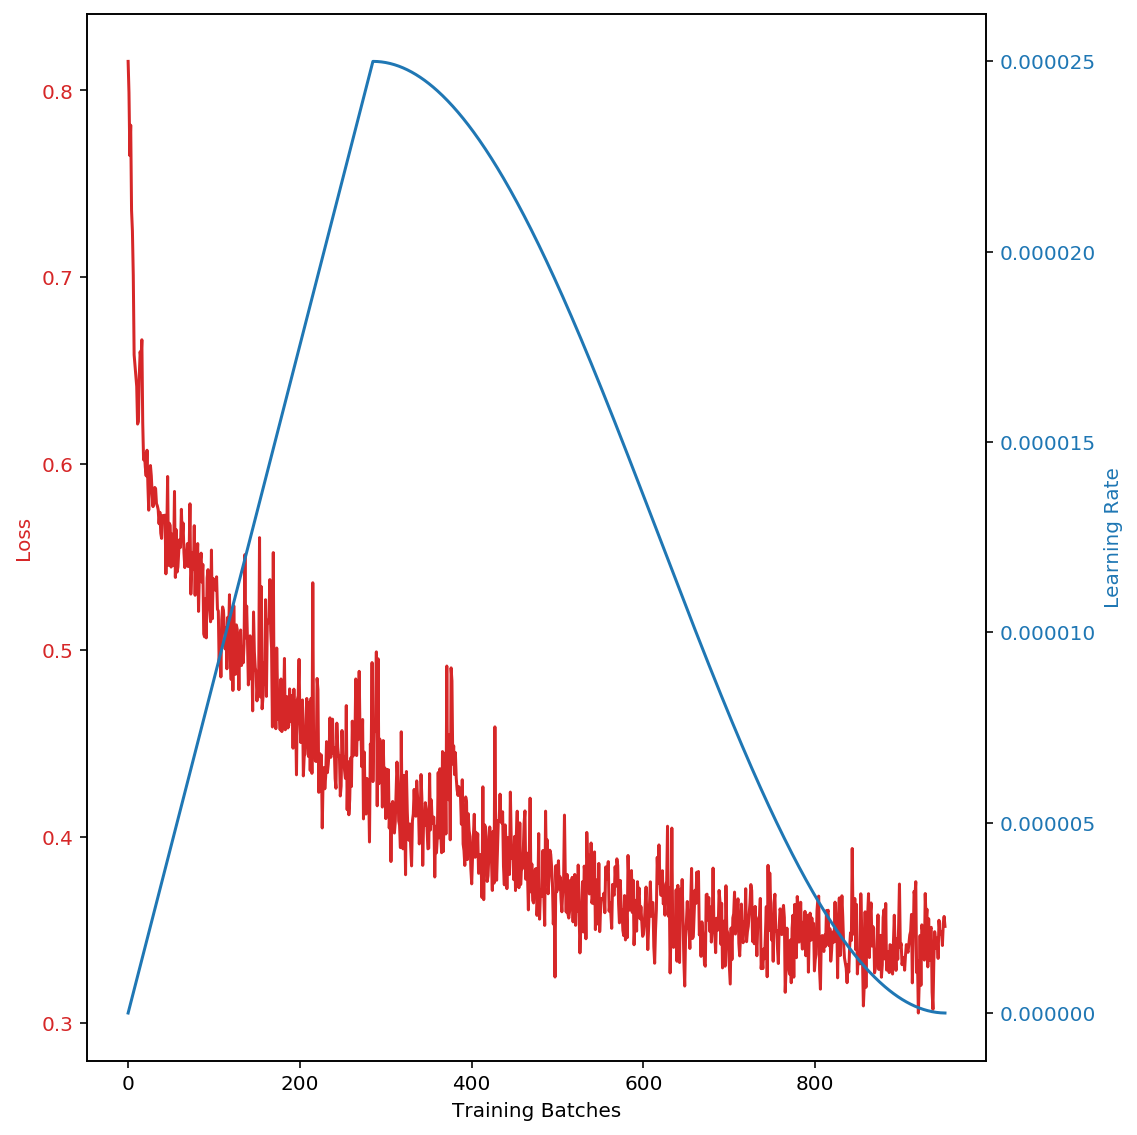

Proba       Preds    
         min   max   min max
Labels                      
0      0.064 0.824     0   1
1      0.157 0.815     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.226,"[0.7740835547447205, 0.22591647505760193]",0,0,0.264,"[0.7355028986930847, 0.2644970715045929]",0,0,0.619,"[0.38055098056793213, 0.6194489598274231]",1,1
1,0.467,"[0.5330854058265686, 0.4669145345687866]",0,1,0.228,"[0.7720579504966736, 0.22794204950332642]",0,0,0.586,"[0.41422411799430847, 0.5857758522033691]",1,1
2,0.425,"[0.5747837424278259, 0.4252162277698517]",0,1,0.459,"[0.5409589409828186, 0.4590410590171814]",0,0,0.399,"[0.600562572479248, 0.3994373679161072]",0,1
3,0.522,"[0.47813206911087036, 0.5218679308891296]",1,0,0.266,"[0.7335094213485718, 0.26649054884910583]",0,1,0.434,"[0.5657378435134888, 0.43426206707954407]",0,0
4,0.375,"[0.6249487400054932, 0.37505120038986206]",0,0,0.594,"[0.4062751531600952, 0.5937248468399048]",1,1,0.428,"[0.571652889251709, 0.428347110748291]",0,1


scores =  {'map': '0.6101', 'acc': '0.5620', 'auc': '0.6444'}


train   val
mean_or_std metric               
mean        map       0.777 0.610
            accuracy  0.761 0.562
            auc       0.851 0.644
std         map       0.000 0.000
            accuracy  0.000 0.000
            auc       0.000 0.000

train                             val                     
    precision recall    f1  supoort precision recall    f1 supoort
neg     0.846  0.767 0.804 5450.000     0.550  0.684 0.610 250.000
pos     0.643  0.750 0.692 3050.000     0.582  0.440 0.501 250.000

In [32]:
adamw = torch.optim.AdamW
adamw_params = dict(lr=1e-4, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-3)
optimizer = adamw
optimizer_params = adamw_params

lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "layer": {
                "2": {
                    "lr": optimizer_params["lr"],
                    "finetune": False
                },
                "3": {
                    "lr": optimizer_params["lr"]/4,
                    "finetune": True
                },
                "4": {
                    "lr": optimizer_params["lr"]/2,
                    "finetune": True
                },
                "5": {
                    "lr": optimizer_params["lr"]/2,
                    "finetune": True
                }
            }
        },
    }
}

epochs = 28
batch_size = 256
model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=768,
                              num_classes=2,
                              gaussian_noise=0.01,
                              dropout=0.1,
                              word_masking_proba=0.15,
                              internal_dims=768,
                              final_layer_builder=fb_1d_loss_builder,
                              n_layers=2,
                              n_encoders=0,
                              n_decoders=0,
                              n_tokens_in=96,
                              n_tokens_out=48,
                              featurizer="transformer",
                              model='distilbert-nsp',
                              loss="focal",
                              classification_head="decoder_ensemble", # head_ensemble
                              dice_loss_coef=0.0,
                              auc_loss_coef=0.5, # 0.1
                              attention_drop_proba=0.0,
                              finetune=False,
                              n_classifier_layers=1,
                              n_classifier_decoders=16, # 4
                             ),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)

kfold = False
results, prfs = train_validate_ntimes(
    model_fn,
    data,
    batch_size,
    epochs,
    kfold=kfold,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched, # reg_sched
    validation_epochs=[17, 27, 34, 41, 47, 51, 54],
    show_model_stats=False,
    sampling_policy="without_replacement",
    prediction_iters=1, evaluate_in_train_mode=False
)
r3, p3 = results, prfs
results
prfs

# 0.853	0.655 (0.765	0.570)
# 0.863	0.651 (0.778	0.570)


### Train Head First

In [5]:
def get_preprocess_text():
    char_level = {"keyboard": 0.1, "char_substitute": 0.4, "char_insert": 0.2, "char_swap": 0.2, 
                  "ocr": 0.0, "char_delete": 0.1}
    char_level = TextAugment([0.1, 0.8, 0.1], char_level)
    word_level = {"fasttext": 0.0, "glove_twitter": 0.0, "glove_wiki": 1.0, "word2vec": 0.0, "split": 0.2,
                 "stopword_insert": 0.0, "word_join": 0.2, "word_cutout": 0.0, "gibberish_insert": 0.0}
    word_level = TextAugment([0.1, 0.8, 0.1], word_level, 
                             fasttext_file="wiki-news-300d-1M-subword.bin", idf_file="/home/ahemf/cache/tfidf_terms.csv")
    sentence_level = {"text_rotate": 0.0, "sentence_shuffle": 0.0, 
                      "one_third_cut": 0.3, "half_cut":0.0, "part_select": 0.75}
    sentence_level = TextAugment([0.75, 0.25], sentence_level)
    gibberish = {"gibberish_insert": 0.25, "punctuation_insert": 0.75, 
                 "punctuation_replace": 0.25, "punctuation_strip": 0.5,}
    gibberish = TextAugment([0.75, 0.25], gibberish)
    def process(text):
        text = sentence_level(text)
        text = word_level(text)
        text = char_level(text)
        text = gibberish(text)
        return text
    return process


preprocess_text = get_preprocess_text()
preprocess_text_test = get_preprocess_text()

data = get_datasets(data_dir="../data/", train_text_transform=preprocess_text, train_image_transform=None, 
                    test_text_transform=None, test_image_transform=None, 
                    cache_images = True, use_images = False, dev=False, test_dev=True,
                    keep_original_text=False, keep_original_image=False, 
                    keep_processed_image=True, keep_torchvision_image=False,)


In [6]:
def aug_sample(sample):
    sample = sample.copy()
    sample.text = preprocess_text(sample.text)
    return sample


Pick stored Model /home/ahemf/cache/distilbert-smclr Model Class =  <class 'transformers.modeling_roberta.RobertaModel'> Tokenizer Class =  <class 'transformers.tokenization_roberta.RobertaTokenizer'>
Autocast =  True Epochs =  4 Divisor = 1 Examples = 10000 Batch Size =  256
Training Samples =  10000 Weighted Sampling =  False Num Batches =  40 Accumulation steps =  1



Epoch =  1 Loss = 0.542793 LR = 0.00004167



Epoch =  2 Loss = 0.399056 LR = 0.00005000



Epoch =  3 Loss = 0.368496 LR = 0.00005000



Epoch =  4 Loss = 0.331142 LR = 0.00005000



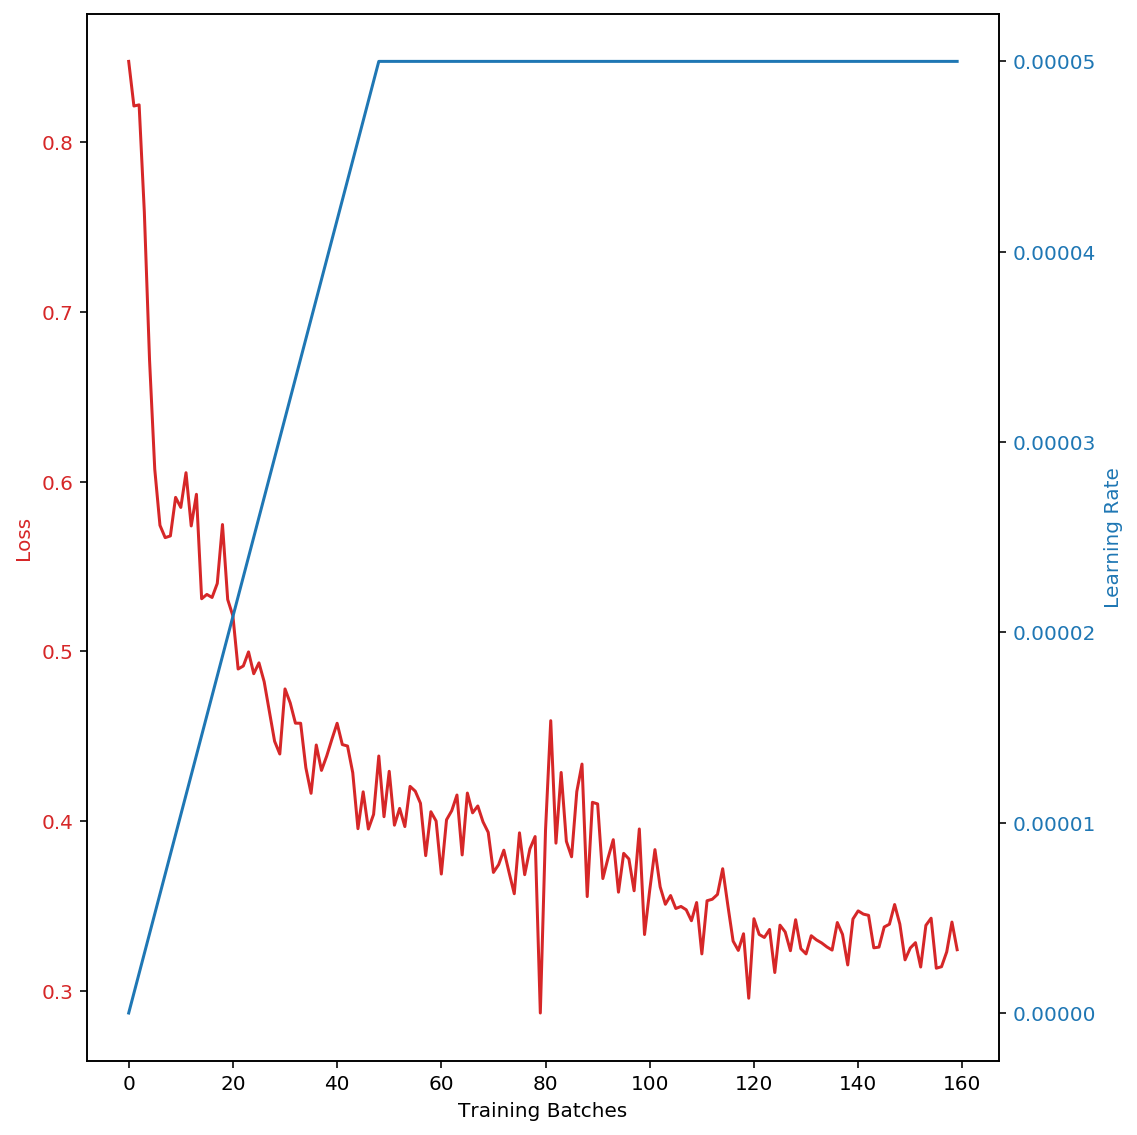

Proba       Preds    
         min   max   min max
Labels                      
0      0.371 0.594     0   1
1      0.371 0.606     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.518,"[0.48153090476989746, 0.5184690952301025]",1,1,0.430,"[0.5701087713241577, 0.4298911690711975]",0,0,0.413,"[0.5866716504096985, 0.41332828998565674]",0,1
1,0.506,"[0.4939875602722168, 0.5060124397277832]",1,0,0.485,"[0.5146956443786621, 0.4853043556213379]",0,0,0.511,"[0.48938482999801636, 0.5106151103973389]",1,0
2,0.483,"[0.5165321826934814, 0.48346784710884094]",0,1,0.374,"[0.6260249614715576, 0.37397500872612]",0,0,0.482,"[0.517991304397583, 0.4820087254047394]",0,1
3,0.466,"[0.5344120860099792, 0.46558791399002075]",0,0,0.416,"[0.5835059285163879, 0.4164940416812897]",0,0,0.456,"[0.5438390374183655, 0.4561610221862793]",0,0
4,0.457,"[0.5431267023086548, 0.4568732678890228]",0,0,0.493,"[0.5068082809448242, 0.4931917190551758]",0,1,0.570,"[0.42979827523231506, 0.5702016949653625]",1,1


Predicted,0,1,Actual Counts,Recall %
Actual,,,,
0,209,41,250.000,83.000
1,189,61,250.000,24.000
Predicted Counts,398,102,500.000,nan
Precision %,52,59,nan,nan


scores =  {'map': '0.5970', 'acc': '0.5400', 'auc': '0.6157'}



scores =  {'map': '0.6032', 'acc': '0.7032', 'auc': '0.7306'}


train   val
mean_or_std metric               
mean        map       0.603 0.597
            accuracy  0.703 0.540
            auc       0.731 0.616
std         map       0.000 0.000
            accuracy  0.000 0.000
            auc       0.000 0.000

train                             val                     
    precision recall    f1  supoort precision recall    f1 supoort
neg     0.726  0.863 0.788 5450.000     0.525  0.836 0.645 250.000
pos     0.630  0.418 0.502 3050.000     0.598  0.244 0.347 250.000

Autocast =  True Epochs =  24 Divisor = 1 Examples = 10000 Batch Size =  128
Training Samples =  10000 Weighted Sampling =  False Num Batches =  79 Accumulation steps =  2
[WARN]: Number of training batches not divisible by accumulation steps, some training batches will be wasted due to this.



Epoch =  1 Loss = 0.316611 LR = 0.00000139



Epoch =  2 Loss = 0.310264 LR = 0.00000278



Epoch =  3 Loss = 0.308955 LR = 0.00000417



Epoch =  4 Loss = 0.306419 LR = 0.00000556



Epoch =  5 Loss = 0.300773 LR = 0.00000695



Epoch =  6 Loss = 0.296008 LR = 0.00000835



Epoch =  7 Loss = 0.294217 LR = 0.00000974



scores =  {'map': '0.6598', 'acc': '0.7286', 'auc': '0.7724'}


Proba       Preds    
         min   max   min max
Labels                      
0      0.327 0.589     0   1
1      0.350 0.599     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.533,"[0.46732741594314575, 0.5326725840568542]",1,0,0.461,"[0.5390260219573975, 0.46097391843795776]",0,1,0.451,"[0.5488740801811218, 0.45112597942352295]",0,1
1,0.458,"[0.5422338247299194, 0.4577661156654358]",0,1,0.472,"[0.5281227827072144, 0.47187724709510803]",0,1,0.417,"[0.5830009579658508, 0.41699910163879395]",0,0
2,0.410,"[0.5903655290603638, 0.40963444113731384]",0,1,0.412,"[0.5884687304496765, 0.4115312397480011]",0,1,0.395,"[0.6048215627670288, 0.3951784074306488]",0,1
3,0.546,"[0.4543096423149109, 0.5456902980804443]",1,1,0.407,"[0.59340900182724, 0.4065909683704376]",0,0,0.548,"[0.45230501890182495, 0.5476950407028198]",1,1
4,0.411,"[0.5894373059272766, 0.4105626344680786]",0,0,0.493,"[0.5074669122695923, 0.4925330579280853]",0,0,0.398,"[0.6019240021705627, 0.3980759382247925]",0,1


Predicted,0,1,Actual Counts,Recall %
Actual,,,,
0,228,22,250.000,91.000
1,214,36,250.000,14.000
Predicted Counts,442,58,500.000,nan
Precision %,51,62,nan,nan


scores =  {'map': '0.6042', 'acc': '0.5280', 'auc': '0.6285'}
Epoch =  7 Train = ['65.98', '72.86', '77.24'] Val = ['60.42', '52.80', '62.85']



Epoch =  8 Loss = 0.288619 LR = 0.00001000



Epoch =  9 Loss = 0.284052 LR = 0.00001000



Epoch =  10 Loss = 0.280024 LR = 0.00001000



Epoch =  11 Loss = 0.276486 LR = 0.00001000


Exception for:  keyboard | Original Text '' '' Final Text '' '' | ['keyboard' 'char_substitute'] argument of type 'NoneType' is not iterable

Epoch =  12 Loss = 0.278471 LR = 0.00001000



Epoch =  13 Loss = 0.274398 LR = 0.00001000


Exception for:  keyboard | Original Text '' '' Final Text '' '' | ['keyboard'] argument of type 'NoneType' is not iterable

Epoch =  14 Loss = 0.269389 LR = 0.00001000



Epoch =  15 Loss = 0.268892 LR = 0.00001000



scores =  {'map': '0.7205', 'acc': '0.7425', 'auc': '0.8085'}


Proba       Preds    
         min   max   min max
Labels                      
0      0.319 0.626     0   1
1      0.362 0.648     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.433,"[0.5669461488723755, 0.4330538213253021]",0,1,0.593,"[0.40721645951271057, 0.5927835702896118]",1,1,0.529,"[0.47093379497528076, 0.5290662050247192]",1,0
1,0.392,"[0.6081743240356445, 0.3918256461620331]",0,0,0.484,"[0.515587568283081, 0.48441243171691895]",0,1,0.461,"[0.5391827821731567, 0.4608171582221985]",0,0
2,0.497,"[0.5025838017463684, 0.49741625785827637]",0,1,0.476,"[0.5237934589385986, 0.47620657086372375]",0,1,0.482,"[0.5177333950996399, 0.4822666645050049]",0,1
3,0.485,"[0.514658510684967, 0.48534151911735535]",0,1,0.427,"[0.5729885101318359, 0.42701148986816406]",0,0,0.595,"[0.40486687421798706, 0.5951331257820129]",1,1
4,0.412,"[0.5878684520721436, 0.41213151812553406]",0,0,0.347,"[0.6528510451316833, 0.34714892506599426]",0,0,0.521,"[0.4794117510318756, 0.5205883383750916]",1,1


Predicted,0,1,Actual Counts,Recall %
Actual,,,,
0,187,63,250.000,74.000
1,153,97,250.000,38.000
Predicted Counts,340,160,500.000,nan
Precision %,55,60,nan,nan


scores =  {'map': '0.6181', 'acc': '0.5680', 'auc': '0.6490'}
Epoch =  15 Train = ['72.05', '74.25', '80.85'] Val = ['61.81', '56.80', '64.90']



Epoch =  16 Loss = 0.267095 LR = 0.00001000



Epoch =  17 Loss = 0.265473 LR = 0.00001000



Epoch =  18 Loss = 0.263395 LR = 0.00001000



Epoch =  19 Loss = 0.263862 LR = 0.00001000



Epoch =  20 Loss = 0.258495 LR = 0.00001000



Epoch =  21 Loss = 0.260497 LR = 0.00001000



scores =  {'map': '0.7505', 'acc': '0.7680', 'auc': '0.8293'}


Proba       Preds    
         min   max   min max
Labels                      
0      0.306 0.610     0   1
1      0.350 0.621     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.415,"[0.585187554359436, 0.41481244564056396]",0,0,0.594,"[0.40570881962776184, 0.5942912101745605]",1,1,0.509,"[0.49116250872612, 0.5088374614715576]",1,1
1,0.552,"[0.448138028383255, 0.5518619418144226]",1,1,0.457,"[0.5432789325714111, 0.4567210078239441]",0,1,0.431,"[0.5688026547431946, 0.4311973750591278]",0,1
2,0.451,"[0.5485901832580566, 0.45140981674194336]",0,1,0.362,"[0.6384623050689697, 0.36153775453567505]",0,1,0.481,"[0.5193102955818176, 0.48068976402282715]",0,1
3,0.462,"[0.5384687185287476, 0.46153128147125244]",0,1,0.426,"[0.5737903714179993, 0.42620962858200073]",0,1,0.435,"[0.5646966099739075, 0.4353034198284149]",0,1
4,0.480,"[0.5197117328643799, 0.4802882671356201]",0,0,0.497,"[0.502677857875824, 0.49732211232185364]",0,1,0.482,"[0.5184906125068665, 0.48150941729545593]",0,1


Predicted,0,1,Actual Counts,Recall %
Actual,,,,
0,210,40,250.000,84.000
1,183,67,250.000,26.000
Predicted Counts,393,107,500.000,nan
Precision %,53,62,nan,nan


scores =  {'map': '0.6172', 'acc': '0.5540', 'auc': '0.6515'}
Epoch =  21 Train = ['75.05', '76.80', '82.93'] Val = ['61.72', '55.40', '65.15']



Epoch =  22 Loss = 0.257491 LR = 0.00001000



Epoch =  23 Loss = 0.256360 LR = 0.00001000



Epoch =  24 Loss = 0.255556 LR = 0.00001000



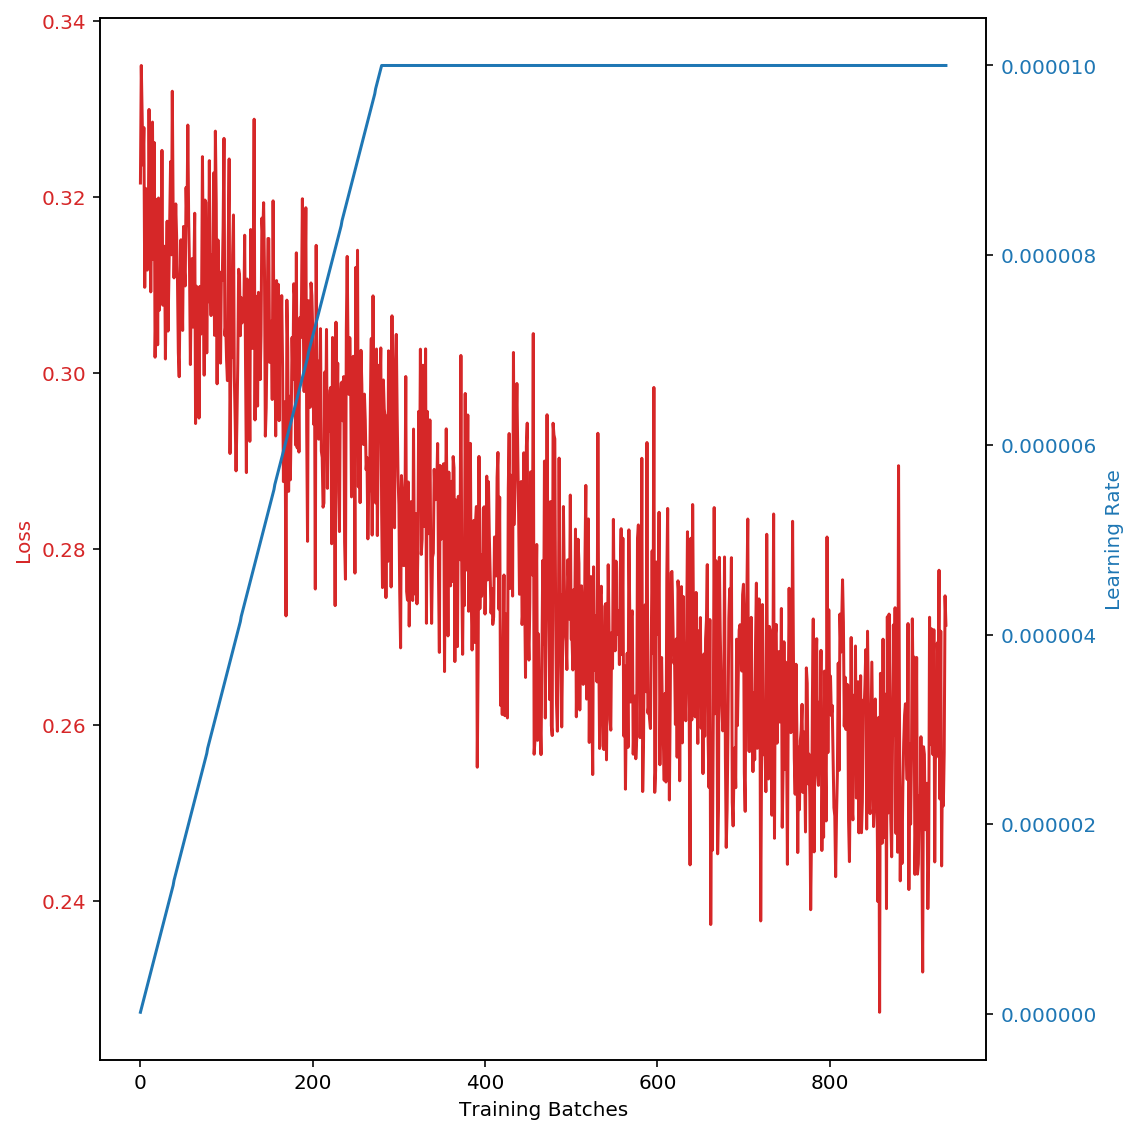

Proba       Preds    
         min   max   min max
Labels                      
0      0.297 0.615     0   1
1      0.341 0.633     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.318,"[0.6816682815551758, 0.3183317184448242]",0,0,0.536,"[0.46378275752067566, 0.536217212677002]",1,1,0.493,"[0.5070774555206299, 0.4929225444793701]",0,0
1,0.435,"[0.565231442451477, 0.43476855754852295]",0,1,0.534,"[0.465553343296051, 0.534446656703949]",1,1,0.341,"[0.6588528752326965, 0.34114715456962585]",0,1
2,0.432,"[0.5681582689285278, 0.43184176087379456]",0,1,0.547,"[0.4528440535068512, 0.5471559166908264]",1,1,0.390,"[0.6099547743797302, 0.39004525542259216]",0,1
3,0.448,"[0.5522812604904175, 0.4477187395095825]",0,0,0.503,"[0.49657437205314636, 0.503425657749176]",1,1,0.453,"[0.5468829870223999, 0.4531170129776001]",0,0
4,0.480,"[0.5202339887619019, 0.47976598143577576]",0,1,0.479,"[0.5208927392959595, 0.4791072607040405]",0,0,0.418,"[0.5823362469673157, 0.4176638126373291]",0,1


Predicted,0,1,Actual Counts,Recall %
Actual,,,,
0,210,40,250.000,84.000
1,183,67,250.000,26.000
Predicted Counts,393,107,500.000,nan
Precision %,53,62,nan,nan


scores =  {'map': '0.6179', 'acc': '0.5540', 'auc': '0.6514'}



scores =  {'map': '0.7623', 'acc': '0.7729', 'auc': '0.8387'}


train   val
mean_or_std metric               
mean        map       0.762 0.618
            accuracy  0.773 0.554
            auc       0.839 0.651
std         map       0.000 0.000
            accuracy  0.000 0.000
            auc       0.000 0.000

train                             val                     
    precision recall    f1  supoort precision recall    f1 supoort
neg     0.798  0.865 0.830 5450.000     0.534  0.840 0.653 250.000
pos     0.716  0.608 0.658 3050.000     0.626  0.268 0.375 250.000

In [7]:
consistency_loss_weight=0.25
num_classes = 2

adamw = torch.optim.AdamW
adamw_params = dict(lr=5e-5, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-2)
optimizer_class = adamw
optimizer_params = adamw_params

lr_strategy = {
    "model": {
        "finetune": False,
    }
}

epochs = 4
batch_size = 256
model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=768,
                              num_classes=2,
                              gaussian_noise=0.01,
                              dropout=0.05,
                              word_masking_proba=0.15,
                              internal_dims=768,
                              final_layer_builder=fb_1d_loss_builder,
                              n_layers=2,
                              n_encoders=0,
                              n_decoders=0,
                              n_tokens_in=96,
                              n_tokens_out=48,
                              featurizer="transformer",
                              model='distilbert-smclr',
                              loss="focal",
                              classification_head="decoder_ensemble", # head_ensemble
                              dice_loss_coef=0.0,
                              auc_loss_coef=0.25,
                              attention_drop_proba=0.01,
                              finetune=False,
                              n_classifier_layers=1,
                              n_classifier_decoders=16, # 4
                             ),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer_class,
                         optimiser_params=optimizer_params)


model, optimizer = model_fn()
kfold = False
results, prfs = train_validate_ntimes(
    (model, optimizer),
    data,
    batch_size,
    epochs,
    kfold=kfold,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=None, # reg_sched
    validation_epochs=[15, 27, 34, 41, 47, 51, 54],
    show_model_stats=False,
    sampling_policy=None,
    prediction_iters=1, evaluate_in_train_mode=False,
    consistency_loss_weight=consistency_loss_weight, num_classes=num_classes,
    aug_1=aug_sample, aug_2=aug_sample,
)
r2, p2 = results, prfs
results
prfs

adamw_params = dict(lr=1e-5, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-3)
optimizer_params = adamw_params
lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "layer": {
                "2": {
                    "lr": optimizer_params["lr"],
                    "finetune": False
                },
                "3": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "4": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "5": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                }
            }
        },
    }
}

_ = group_wise_finetune(model, lr_strategy)
params_conf, _ = group_wise_lr(model, lr_strategy)
optimizer = optimizer_class(params_conf, **optimizer_params)


epochs = 24
batch_size=128
kfold = False
results, prfs = train_validate_ntimes(
    (model, optimizer),
    data,
    batch_size,
    epochs,
    kfold=kfold,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=None, # reg_sched
    validation_epochs=[7, 15, 21, 31, 41, 46, 51, 54, 62],
    show_model_stats=False,
    accumulation_steps=2,
    sampling_policy=None,
    prediction_iters=1, evaluate_in_train_mode=False,
    consistency_loss_weight=consistency_loss_weight, num_classes=num_classes,
    aug_1=aug_sample, aug_2=aug_sample,
)
r4, p4 = results, prfs
results
prfs

# 48-96
# 0.842	0.658 (0.767	0.572)
# 0.847	0.652 (0.766	0.574)

# Very high W/C
# 0.841	0.652 (0.760	0.570)
# 0.840	0.653 (0.759	0.576)
# 0.839	0.650 (0.760	0.568)
# 0.842	0.645 (0.762	0.570)
# 0.839	0.653 (0.761	0.574)


# # No stops + Very High W/C Reg
# 0.836	0.652 (0.754	0.588)
# 0.839	0.650 (0.762	0.576)

# 48-64 0.0 gauss
# 0.848	0.658 (0.768	0.578)
# 0.849	0.656 (0.766	0.570)


# SimCLR
# 0.856	0.657 (0.767	0.590)
# 0.859	0.654 (0.778	0.568)

# 0.828	0.651 (0.765	0.566)
# Replace multiple puncts with space and strip


In [8]:
preds, probas = [], []
dataset = convert_dataframe_to_dataset(data["dev"], data["metadata"], True)
from tqdm.auto import tqdm, trange
for i in trange(100):
    proba_list, all_probas_list, predictions_list, labels_list = generate_predictions(model, 128, dataset)
    probas.append(all_probas_list)
    preds.append(predictions_list)
    
from collections import Counter
preds_voted = [Counter(p).most_common()[0][0] for p in zip(*preds)]
probas_mean = torch.tensor(probas).mean(0)
pred_probas = probas_mean.max(dim=1).indices
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report
from sklearn.metrics import precision_recall_fscore_support, accuracy_score


print(accuracy_score(labels_list, preds_voted))
print(accuracy_score(labels_list, pred_probas))
print(roc_auc_score(labels_list, probas_mean[:, 1].tolist(), multi_class="ovo", average="macro"))




0.554
0.538
0.6377919999999999


## Multi-eval decoder ensemble

# Predict

In [5]:
import random
def get_preprocess_text():
    char_level = {"keyboard": 0.1, "char_substitute": 0.4, "char_insert": 0.2, "char_swap": 0.2, 
                  "ocr": 0.0, "char_delete": 0.1}
    char_level = TextAugment([0.1, 0.6, 0.3], char_level)
    word_level = {"split": 0.2,
                 "stopword_insert": 0.0, "word_join": 0.2, "word_cutout": 0.0, "punctuation_continue": 0.5}
    word_level = TextAugment([0.1, 0.6, 0.3], word_level, 
                             fasttext_file="wiki-news-300d-1M-subword.bin")
    sentence_level = {"text_rotate": 0.0, "sentence_shuffle": 0.0, "glove_twitter": 0.5,
                      "one_third_cut": 0.3, "half_cut":0.0, "part_select": 0.75}
    sentence_level = TextAugment([0.75, 0.25], sentence_level, idf_file="/home/ahemf/cache/tfidf_terms.csv"
                                )
    gibberish = {"gibberish_insert": 0.25, "punctuation_insert": 0.75, 
                 "punctuation_replace": 0.25, "punctuation_strip": 0.5,}
    gibberish = TextAugment([0.5, 0.5], gibberish)
    translation = {"dab":1.0, "punctuation_insert": 0.01}
    translation = TextAugment([0.0, 1.0], translation, dab_file="/home/ahemf/cache/fdab.csv")
    def process(text, **kwargs):
        if random.random() < 0.5:
            text = sentence_level(text, **kwargs)
            text = word_level(text, **kwargs)
            text = char_level(text, **kwargs)
            text = gibberish(text, **kwargs)
        else:
            text = translation(text, **kwargs)
            text = char_level(text, **kwargs)
        return text
    return process


preprocess_text = get_preprocess_text()
preprocess_text_test = get_preprocess_text()

data = get_datasets(data_dir="../data/", train_text_transform=preprocess_text, train_image_transform=None, 
                    test_text_transform=None, test_image_transform=None, 
                    cache_images = True, use_images = False, dev=False, test_dev=True,
                    keep_original_text=False, keep_original_image=False, 
                    keep_processed_image=True, keep_torchvision_image=False,)

def aug_sample(sample):
    sample = sample.copy()
    sample.text = preprocess_text(sample.text, identifier=sample.id)
    return sample


# Clean text


Pick stored Model /home/ahemf/cache/distilbert-smclr Model Class =  <class 'transformers.modeling_roberta.RobertaModel'> Tokenizer Class =  <class 'transformers.tokenization_roberta.RobertaTokenizer'>
Autocast =  True Epochs =  12 Divisor = 2 Examples = 5000 Batch Size =  128
Training Samples =  10000 Weighted Sampling =  True Num Batches =  40 Accumulation steps =  1



Epoch =  1 Loss = 0.563856 LR = 0.00001389



Epoch =  2 Loss = 0.444771 LR = 0.00002778



Epoch =  3 Loss = 0.420364 LR = 0.00004167



Epoch =  4 Loss = 0.386014 LR = 0.00005000



Epoch =  5 Loss = 0.359710 LR = 0.00005000



Epoch =  6 Loss = 0.348403 LR = 0.00005000



Epoch =  7 Loss = 0.327186 LR = 0.00005000



Epoch =  8 Loss = 0.315977 LR = 0.00005000



Epoch =  9 Loss = 0.304043 LR = 0.00005000



Epoch =  10 Loss = 0.303870 LR = 0.00005000



Epoch =  11 Loss = 0.321634 LR = 0.00005000



Epoch =  12 Loss = 0.289973 LR = 0.00005000



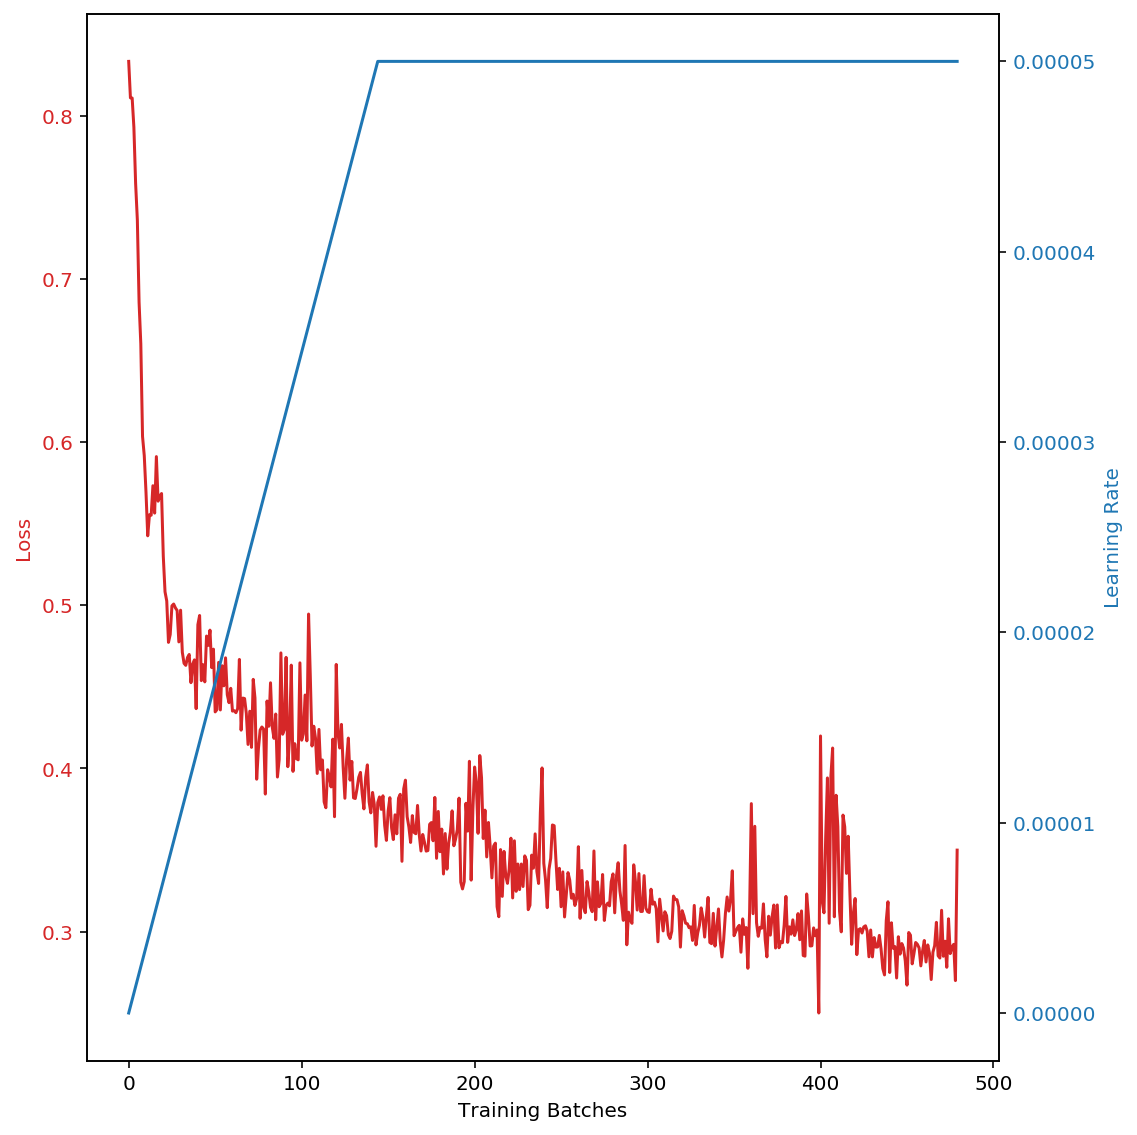

Proba       Preds    
         min   max   min max
Labels                      
0      0.346 0.592     0   1
1      0.353 0.611     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.440,"[0.5598278045654297, 0.44017210602760315]",0,0,0.611,"[0.38909584283828735, 0.6109040975570679]",1,1,0.425,"[0.5752896666526794, 0.42471036314964294]",0,1
1,0.491,"[0.5089248418807983, 0.4910751283168793]",0,1,0.501,"[0.49855008721351624, 0.5014499425888062]",1,1,0.452,"[0.5479230880737305, 0.4520769417285919]",0,1
2,0.448,"[0.5521605014801025, 0.4478394389152527]",0,1,0.429,"[0.5713897943496704, 0.42861026525497437]",0,1,0.446,"[0.5538274645805359, 0.4461725354194641]",0,0
3,0.435,"[0.5648903846740723, 0.43510961532592773]",0,1,0.346,"[0.654008150100708, 0.3459918200969696]",0,0,0.484,"[0.5158266425132751, 0.48417338728904724]",0,0
4,0.459,"[0.5406081676483154, 0.4593918025493622]",0,0,0.467,"[0.533143937587738, 0.46685606241226196]",0,1,0.483,"[0.5168981552124023, 0.48310187458992004]",0,0


Predicted,0,1,Actual Counts,Recall %
Actual,,,,
0,217,33,250.000,86.000
1,196,54,250.000,21.000
Predicted Counts,413,87,500.000,nan
Precision %,52,62,nan,nan


scores =  {'map': '0.6099', 'acc': '0.5420', 'auc': '0.6299'}



scores =  {'map': '0.6104', 'acc': '0.7118', 'auc': '0.7342'}


train   val
mean_or_std metric               
mean        map       0.610 0.610
            accuracy  0.712 0.542
            auc       0.734 0.630
std         map       0.000 0.000
            accuracy  0.000 0.000
            auc       0.000 0.000

train                             val                     
    precision recall    f1  supoort precision recall    f1 supoort
neg     0.723  0.891 0.799 5450.000     0.525  0.868 0.655 250.000
pos     0.668  0.391 0.493 3050.000     0.621  0.216 0.320 250.000

Autocast =  True Epochs =  60 Divisor = 2 Examples = 5000 Batch Size =  128
Training Samples =  10000 Weighted Sampling =  True Num Batches =  40 Accumulation steps =  4



Epoch =  1 Loss = 0.286623 LR = 0.00000056



Epoch =  2 Loss = 0.284429 LR = 0.00000111



Epoch =  3 Loss = 0.283149 LR = 0.00000167



Epoch =  4 Loss = 0.284071 LR = 0.00000222



Epoch =  5 Loss = 0.280381 LR = 0.00000278



Epoch =  6 Loss = 0.282336 LR = 0.00000333



Epoch =  7 Loss = 0.284285 LR = 0.00000389



scores =  {'map': '0.6218', 'acc': '0.6927', 'auc': '0.7444'}



scores =  {'map': '0.6094', 'acc': '0.5860', 'auc': '0.6304'}
Epoch =  7 Train = ['62.18', '69.27', '74.44'] Val = ['60.94', '58.60', '63.04']



Epoch =  8 Loss = 0.280541 LR = 0.00000444



Epoch =  9 Loss = 0.279536 LR = 0.00000500



Epoch =  10 Loss = 0.280382 LR = 0.00000556


In [ ]:
consistency_loss_weight=0.25
num_classes = 2

adamw = torch.optim.AdamW
adamw_params = dict(lr=5e-5, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-2)
optimizer_class = adamw
optimizer_params = adamw_params

lr_strategy = {
    "model": {
        "finetune": False,
    }
}

epochs = 6
batch_size = 128
model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=768,
                              num_classes=2,
                              gaussian_noise=0.01,
                              dropout=0.05, # 0.1
                              word_masking_proba=0.15,
                              internal_dims=768,
                              final_layer_builder=fb_1d_loss_builder,
                              n_layers=2,
                              n_encoders=0,
                              n_decoders=0,
                              n_tokens_in=96,
                              n_tokens_out=48,
                              featurizer="transformer",
                              model='distilbert-smclr',
                              loss="focal",
                              classification_head="decoder_ensemble", # head_ensemble
                              dice_loss_coef=0.0,
                              auc_loss_coef=0.25, # 0.5
                              attention_drop_proba=0.1,
                              finetune=False,
                              n_classifier_layers=1,
                              n_classifier_decoders=16, # 4
                             ),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer_class,
                         optimiser_params=optimizer_params)


model, optimizer = model_fn()
kfold = False
results, prfs, _ = train_validate_ntimes(
    (model, optimizer),
    data,
    batch_size,
    epochs,
    kfold=kfold,
    accumulation_steps=1,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched, # reg_sched
    validation_epochs=[15, 27, 34, 41, 47, 51, 54],
    show_model_stats=False,
    sampling_policy="uda_without_replacement",
    prediction_iters=1, evaluate_in_train_mode=False,
    consistency_loss_weight=consistency_loss_weight, num_classes=num_classes,
    aug_1=aug_sample, aug_2=aug_sample,
)
r2, p2 = results, prfs
results
prfs

adamw_params = dict(lr=1e-5, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-3)
optimizer_params = adamw_params
lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "layer": {
                "2": {
                    "lr": optimizer_params["lr"],
                    "finetune": False
                },
                "3": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "4": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "5": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                }
            }
        },
    }
}

_ = group_wise_finetune(model, lr_strategy)
params_conf, _ = group_wise_lr(model, lr_strategy)
optimizer = optimizer_class(params_conf, **optimizer_params)


epochs = 30
batch_size=128
kfold = False
submission, text_model, val_stats = train_and_predict(
    (model, optimizer),
    data,
    batch_size,
    epochs,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched, # reg_sched
    validation_epochs=[7, 15, 21, 26, 30, 35, 41, 46, 51, 54, 60, 62],
    show_model_stats=False,
    accumulation_steps=4,
    sampling_policy="uda_without_replacement",
    consistency_loss_weight=consistency_loss_weight, num_classes=num_classes,
    aug_1=aug_sample, aug_2=aug_sample,
)
submission.to_csv("submission.csv",index=False)
submission.sample(5)

# 0.722	0.729
# Epoch =  7 Train = ['65.58', '70.96', '76.21'] Val = ['63.17', '59.00', '65.39']
# Epoch =  15 Train = ['71.83', '74.37', '80.36'] Val = ['65.55', '56.40', '69.26']
# Epoch =  21 Train = ['74.72', '76.03', '82.47'] Val = ['67.23', '58.80', '70.98']
# Epoch =  24 Train = ['76.21', '76.28', '83.56'] Val = ['68.91', '61.60', '72.54']
# Epoch =  27 Train = ['77.27', '76.88', '84.36'] Val = ['70.52', '62.20', '73.87']
# Epoch =  30 Train = ['78.28', '77.12', '85.13'] Val = ['71.45', '62.40', '74.26']

In [12]:
val_stats # 0.05

{7: {'train': ['64.63', '72.49', '76.33'], 'val': ['61.37', '54.80', '63.18']},
 15: {'train': ['70.02', '74.67', '79.49'],
  'val': ['61.84', '55.00', '64.29']},
 21: {'train': ['72.53', '75.73', '81.13'],
  'val': ['61.94', '56.40', '64.80']},
 24: {'train': ['73.52', '75.98', '81.85'],
  'val': ['62.03', '56.40', '65.27']},
 27: {'train': ['74.39', '76.54', '82.50'],
  'val': ['61.82', '54.20', '65.16']},
 30: {'train': ['75.22', '76.78', '83.05'],
  'val': ['62.03', '56.00', '65.12']}}

In [10]:
val_stats # 0.1

{7: {'train': ['64.77', '72.45', '76.33'], 'val': ['61.43', '54.00', '63.34']},
 15: {'train': ['70.01', '74.64', '79.49'],
  'val': ['61.42', '55.60', '64.54']},
 21: {'train': ['72.38', '75.65', '81.04'],
  'val': ['61.57', '56.20', '65.33']},
 24: {'train': ['73.62', '76.14', '81.86'],
  'val': ['61.60', '55.40', '65.05']},
 27: {'train': ['74.44', '76.55', '82.49'],
  'val': ['61.88', '55.40', '65.55']},
 30: {'train': ['75.35', '76.94', '83.25'],
  'val': ['61.86', '53.80', '65.79']}}

In [ ]:
adamw = torch.optim.AdamW
adamw_params = dict(lr=1e-4, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-3)
optimizer_class = adamw
optimizer_params = adamw_params

lr_strategy = {
    "model": {
        "finetune": False,
    }
}

epochs = 6
batch_size = 256
model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=768,
                              num_classes=2,
                              gaussian_noise=0.01,
                              dropout=0.05,
                              word_masking_proba=0.1,
                              internal_dims=768,
                              final_layer_builder=fb_1d_loss_builder,
                              n_layers=2,
                              n_encoders=0,
                              n_decoders=0,
                              n_tokens_in=96,
                              n_tokens_out=48,
                              featurizer="transformer",
                              model='distilbert-smclr',
                              loss="focal",
                              classification_head="decoder_ensemble", # head_ensemble
                              dice_loss_coef=0.0,
                              auc_loss_coef=0.5, # 0.1
                              attention_drop_proba=0.0,
                              finetune=False,
                              n_classifier_layers=1,
                              n_classifier_decoders=16, # 4
                             ),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer_class,
                         optimiser_params=optimizer_params)


model, optimizer = model_fn()
kfold = False
results, prfs = train_validate_ntimes(
    (model, optimizer),
    data,
    batch_size,
    epochs,
    kfold=kfold,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched, # reg_sched
    validation_epochs=[15, 27, 34, 41, 47, 51, 54],
    show_model_stats=False,
    sampling_policy="without_replacement",
    prediction_iters=1, evaluate_in_train_mode=False
)
r2, p2 = results, prfs
results
prfs

adamw_params = dict(lr=3e-5, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-3)
optimizer_params = adamw_params
lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "layer": {
                "2": {
                    "lr": optimizer_params["lr"],
                    "finetune": False
                },
                "3": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "4": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "5": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                }
            }
        },
    }
}

_ = group_wise_finetune(model, lr_strategy)
params_conf, _ = group_wise_lr(model, lr_strategy)
optimizer = optimizer_class(params_conf, **optimizer_params)


In [ ]:
epochs = 24
submission, text_model = train_and_predict((model, optimizer), data, batch_size, epochs, 
                                           scheduler_init_fn=scheduler_init_fn, 
                                           model_call_back=reg_sched,
                                           sampling_policy="without_replacement",
                                           validation_epochs=[15, 34, 42, 46],
                                          )
submission.to_csv("submission.csv",index=False)
submission.sample(5)
